In [1]:
import configparser
import psycopg2
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import confusion_matrix,auc,accuracy_score,classification_report, roc_auc_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from scipy.stats import ttest_ind

In [38]:
config = configparser.ConfigParser()
config.read('C:\Files and Folders\project\dwh.cfg')

['C:\\Files and Folders\\project\\dwh.cfg']

In [44]:
conn = psycopg2.connect("host={} dbname={} user={} password={} port={}".format(*config['CLUSTER'].values()))
cur = conn.cursor()

In [45]:
query = 'SELECT * FROM trainingChurn'
df = pd.read_sql(query, conn)
cur.close()
conn.close()
df.head()

,user_id,nb_visits,nb_purchase,amount_purchase,nb_products_seen,nb__distinct_products,nb_distinct_category0,nb_distinct_category1,nb_distinct_category2,nb_distinct_product_purchased,...,nb_associated_months,nb_days_last_activity,nb_days_last_purchase,nb_active_months,nb_active_purchase_months,nb_purchase_total,amount_purchase_total,no_activity_evaluation_period,amount_purchase_evaluation_period,no_purchase_evaluation_period
0,52817,22,7,257.0,22,21,9,14,14,6,...,6,30,38,5,4,9,280.0,0,10,0
1,81564,1381,7,100.0,1156,633,11,73,75,7,...,6,1,40,7,6,13,205.0,0,7,0
2,60399,140,5,149.0,101,98,9,36,36,5,...,6,1,45,7,4,9,218.0,0,1,0
3,112207,196,3,90.0,123,113,10,44,44,3,...,6,2,3,7,3,3,90.0,0,3,0
4,106464,339,7,147.0,237,194,11,59,59,7,...,6,1,41,7,5,10,198.0,0,6,0


In [2]:
df = pd.read_csv(r'Data\final_dataset.csv').sample(frac=1, random_state=42)
df.head()

,user_id,nb_visits,nb_purchase,amount_purchase,nb_products_seen,nb__distinct_products,nb_distinct_category0,nb_distinct_category1,nb_distinct_category2,nb_distinct_product_purchased,...,nb_associated_months,nb_days_last_activity,nb_days_last_purchase,nb_active_months,nb_active_purchase_months,nb_purchase_total,amount_purchase_total,no_activity_evaluation_period,amount_purchase_evaluation_period,no_purchase_evaluation_period
1474,77778,6,2,143.0,4,4,2,3,3,2,...,0,37,37,1,1,2,143.0,1,0,1
3172,47268,26,3,262.0,22,21,6,14,14,3,...,1,57,66,2,1,3,262.0,0,0,1
2676,142183,84,9,123.0,75,71,10,31,31,9,...,3,2,91,3,2,9,123.0,0,7,0
2083,51311,23,6,81.0,20,19,6,16,16,5,...,1,93,100,2,2,26,772.0,1,0,1
1106,101072,14,1,100.0,11,11,4,9,9,1,...,1,103,122,2,1,1,100.0,0,1,0


In [3]:
df.describe()

,user_id,nb_visits,nb_purchase,amount_purchase,nb_products_seen,nb__distinct_products,nb_distinct_category0,nb_distinct_category1,nb_distinct_category2,nb_distinct_product_purchased,...,nb_associated_months,nb_days_last_activity,nb_days_last_purchase,nb_active_months,nb_active_purchase_months,nb_purchase_total,amount_purchase_total,no_activity_evaluation_period,amount_purchase_evaluation_period,no_purchase_evaluation_period
count,3863.000000,3863.000000,3863.000000,3.863000e+03,3863.000000,3863.000000,3863.000000,3863.000000,3863.000000,3863.000000,...,3863.000000,3863.000000,3863.000000,3863.000000,3863.000000,3863.000000,3.863000e+03,3863.000000,3863.000000,3863.000000
mean,75507.146518,44.045302,3.322547,2.433485e+04,32.441626,28.421175,4.822159,11.853999,11.910950,3.302615,...,2.057209,37.887393,50.089827,2.744499,1.672017,4.088532,2.436013e+04,0.569247,0.827854,0.789283
std,43805.071306,157.003342,5.404222,9.469574e+05,131.566783,86.610062,3.188487,14.447602,14.596731,5.388559,...,2.331330,34.660654,35.117307,2.103166,1.193744,7.211564,9.469568e+05,0.495246,3.677740,0.407871
min,1.000000,1.000000,1.000000,3.600000e+01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.600000e+01,0.000000,0.000000,0.000000
25%,37064.000000,3.000000,1.000000,4.700000e+01,3.000000,3.000000,2.000000,2.000000,2.000000,1.000000,...,0.000000,8.000000,20.000000,1.000000,1.000000,1.000000,4.800000e+01,0.000000,0.000000,1.000000
50%,74177.000000,9.000000,2.000000,6.900000e+01,8.000000,7.000000,4.000000,6.000000,6.000000,2.000000,...,1.000000,27.000000,42.000000,2.000000,1.000000,2.000000,7.500000e+01,1.000000,0.000000,1.000000
75%,114795.500000,30.500000,4.000000,1.250000e+02,23.000000,22.000000,7.000000,15.000000,15.000000,3.000000,...,4.000000,63.000000,81.000000,4.000000,2.000000,4.000000,1.420000e+02,1.000000,0.000000,1.000000
max,151846.000000,5966.000000,106.000000,4.109308e+07,5703.000000,3006.000000,11.000000,107.000000,114.000000,106.000000,...,6.000000,122.000000,122.000000,7.000000,7.000000,143.000000,4.109308e+07,1.000000,102.000000,1.000000


## Exploratory Data Analysis
Missing data check

In [4]:
df.isnull().sum()

user_id                                      0
nb_visits                                    0
nb_purchase                                  0
amount_purchase                              0
nb_products_seen                             0
nb__distinct_products                        0
nb_distinct_category0                        0
nb_distinct_category1                        0
nb_distinct_category2                        0
nb_distinct_product_purchased                0
nb_distinct_category_purchased               0
nb_visits_last_month                         0
nb_purchase_last_month                       0
amount_purchase_last_month                   0
nb_products_seen_last_month                  0
nb__distinct_products_last_month             0
nb_distinct_category0_last_month             0
nb_distinct_category1_last_month             0
nb_distinct_category2_last_month             0
nb_distinct_product_purchased_last_month     0
nb_distinct_category_purchased_last_month    0
nb_associated

Checking for Class Imbalance

Text(0.5, 1.0, 'Number of Users Churned')

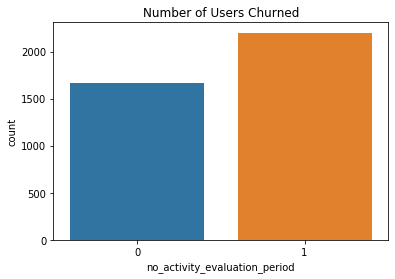

In [5]:
sns.countplot(x='no_activity_evaluation_period', data=df).set_title('Number of Users Churned')

Correlation and scatter Plot

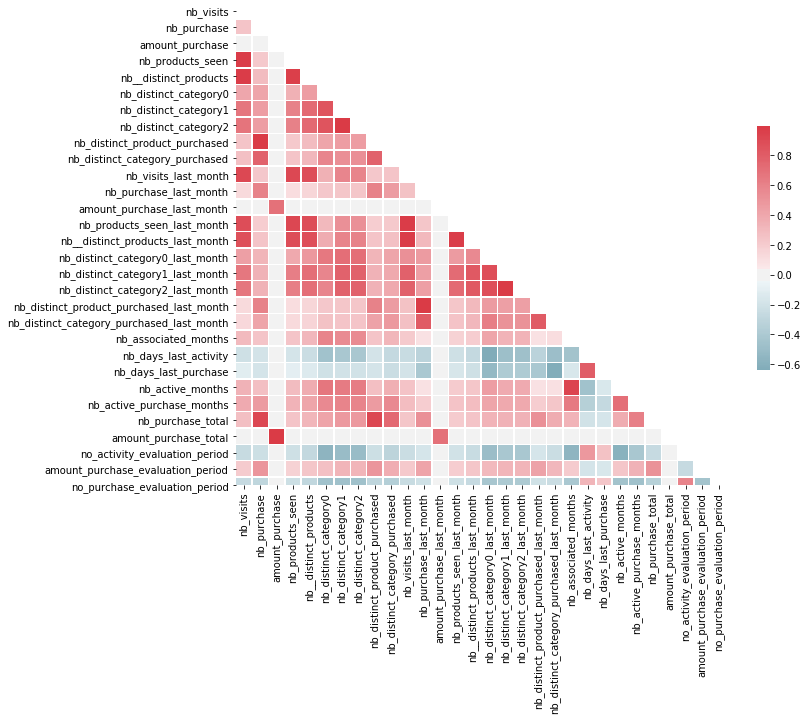

In [7]:
corr = df.loc[:, df.columns != 'user_id'].corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
#corr

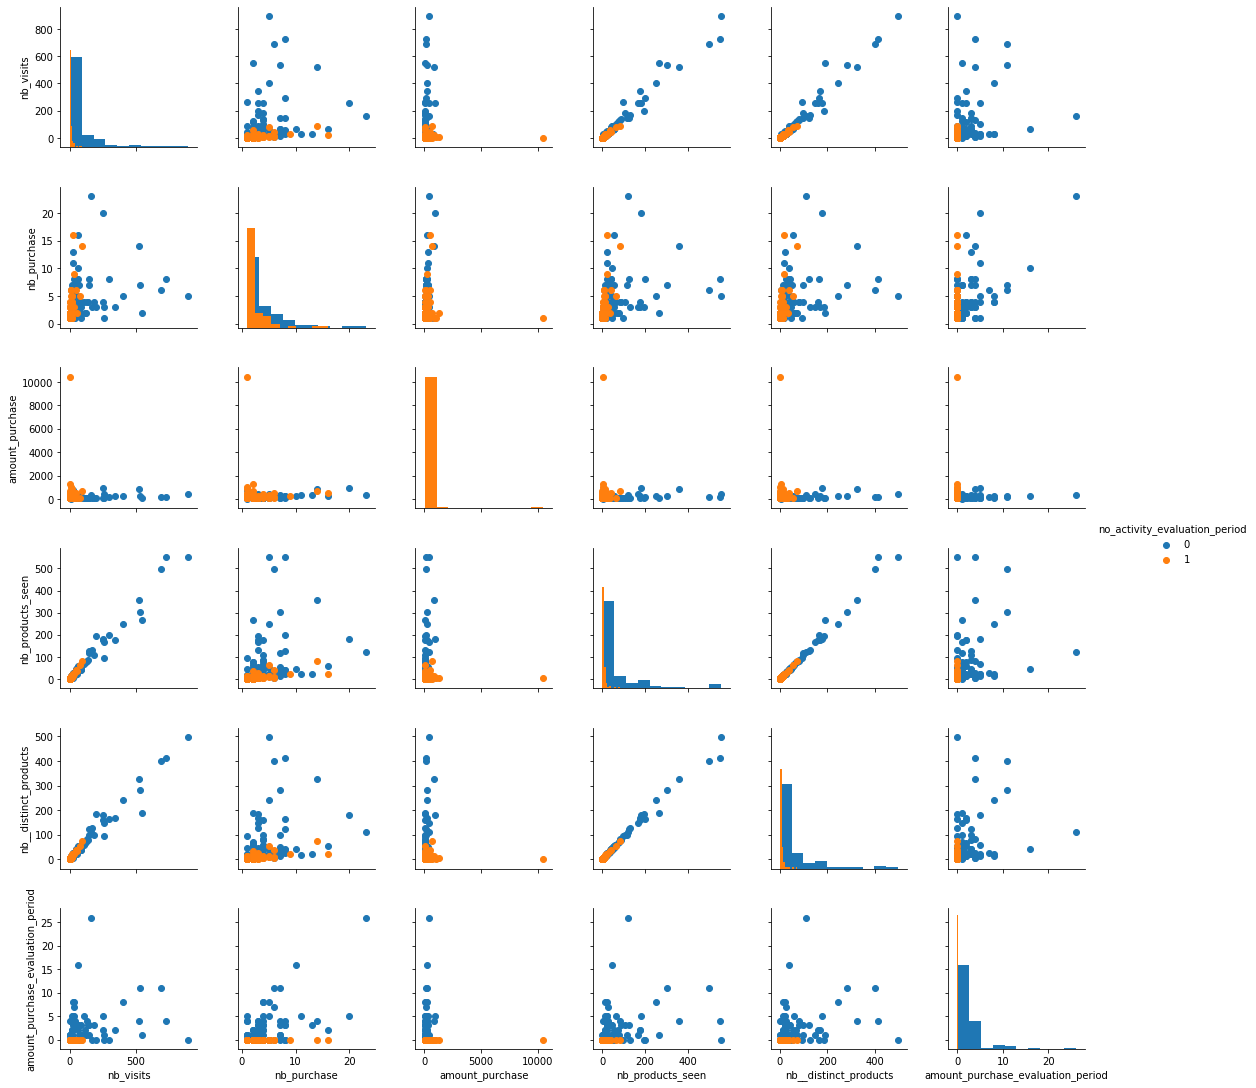

In [51]:
df_sample = pd.concat([df.iloc[:,1:6],df.iloc[:,-3:-1]], axis=1).sample(frac=0.05)
g = sns.PairGrid(df_sample, hue="no_activity_evaluation_period")
g = g.map_diag(plt.hist)
g = g.map_offdiag(plt.scatter)
g = g.add_legend()

Spliting Data into Test and Train Dataset

In [4]:
X = df.loc[:,~df.columns.isin(['user_id', 'no_activity_evaluation_period','amount_purchase_evaluation_period','no_purchase_evaluation_period'])]
y = df.loc[:, 'no_activity_evaluation_period']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

#X_train['Y'] = y_train
#X_train = X_train.sample(frac=0.10, random_state=42)
#y_train = X_train['Y']
#X_train = X_train.drop('Y', axis=1)

X_train.head()

,nb_visits,nb_purchase,amount_purchase,nb_products_seen,nb__distinct_products,nb_distinct_category0,nb_distinct_category1,nb_distinct_category2,nb_distinct_product_purchased,nb_distinct_category_purchased,...,nb_distinct_category2_last_month,nb_distinct_product_purchased_last_month,nb_distinct_category_purchased_last_month,nb_associated_months,nb_days_last_activity,nb_days_last_purchase,nb_active_months,nb_active_purchase_months,nb_purchase_total,amount_purchase_total
1840,21,4,93.0,20,19,6,11,12,4,4,...,4,0,0,2,22,81,2,1,4,93.0
906,1,1,70.0,1,1,1,1,1,1,1,...,0,0,0,0,96,96,1,1,1,70.0
794,165,11,270.0,133,120,9,48,49,11,5,...,5,0,0,3,22,45,4,3,11,270.0
3308,1,1,129.0,1,1,1,1,1,1,1,...,1,1,1,0,29,29,1,1,1,129.0
2656,16,3,79.0,16,15,7,13,13,3,3,...,0,0,0,0,103,104,1,1,3,79.0


In [5]:
pt = PowerTransformer(method='yeo-johnson',standardize=True)
X_train_pt = pt.fit_transform(X_train)
X_test_pt = pt.transform(X_test)
std = StandardScaler()
X_train_std = std.fit_transform(X_train)
X_test_std = std.transform(X_test)

Text(0.5, 1.0, 'Distribution : number of visits')

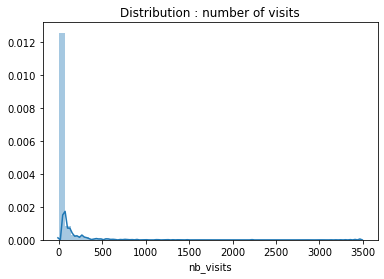

In [11]:
sns.distplot(X_train['nb_visits']).set_title('Distribution : number of visits')

Text(0.5, 0, 'nb_visits')

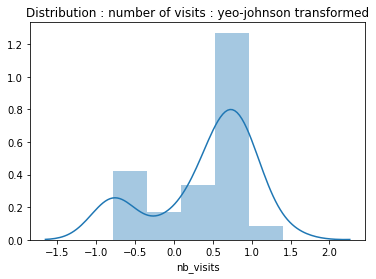

In [17]:
ax = sns.distplot(X_train_pt[0,:])
ax.set_title('Distribution : number of visits : yeo-johnson transformed')
ax.set_xlabel('nb_visits')

Text(0.5, 0, 'nb_visits')

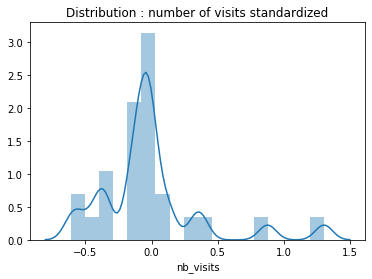

In [15]:
ax = sns.distplot(X_train_std[0,:])
ax.set_title('Distribution : number of visits standardized')
ax.set_xlabel('nb_visits')

In [8]:
def ttest(X, y, equal_var=True):
    result = []
    for col in X.columns:
        tvalue,pvalue = ttest_ind(X[y==0][col],X[y==1][col], equal_var=equal_var)
        result.append((col, y.name, float(tvalue), float(pvalue)))
    return pd.DataFrame(result, columns = ['Var1', 'Var2', 'tvalue', 'pvalue'])

T- test to check statistical significance

In [54]:
t_df = ttest(X, y, equal_var=False)
t_df[t_df['pvalue'] >= 0.05]

,Var1,Var2,tvalue,pvalue
2,amount_purchase,no_activity_evaluation_period,0.029773,0.976250
12,amount_purchase_last_month,no_activity_evaluation_period,1.000859,0.317041
26,amount_purchase_total,no_activity_evaluation_period,0.030682,0.975525


In [55]:
ttest_ind(np.log(X[y==0]['amount_purchase_total']+1),np.log(X[y==1]['amount_purchase_total']+1), equal_var=True)

Ttest_indResult(statistic=12.414334957669114, pvalue=9.967042593023013e-35)

Text(0, 0.5, 'log(nb_visits)')

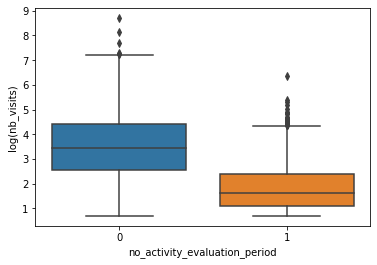

In [7]:
sns.boxplot(y=np.log(df['nb_visits']+1),x= 'no_activity_evaluation_period', data=df).set_ylabel('log(nb_visits)')

## Modeling

In [73]:
#Random Forest Model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train,y_train)
pd.DataFrame(zip(X_train.columns,rf_model.feature_importances_), columns = ['Features','Importance']).sort_values('Importance', ascending=False)

,Features,Importance
23,nb_active_months,0.177715
21,nb_days_last_activity,0.121025
0,nb_visits,0.102029
6,nb_distinct_category1,0.058217
22,nb_days_last_purchase,0.055820
4,nb__distinct_products,0.055260
2,amount_purchase,0.054337
26,amount_purchase_total,0.046802
3,nb_products_seen,0.036346
20,nb_associated_months,0.035496


In [74]:
param={'n_estimators':[100,300,500,1000,1500]}
clf = GridSearchCV(rf_model, cv=5,param_grid=param, n_jobs=-1, scoring ='accuracy')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(clf.best_score_,clf.best_params_)
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred),roc_auc_score(y_test,y_pred), recall_score(y_test,y_pred), precision_score(y_test,y_pred))

0.8122977346278317 {'n_estimators': 100}
[[261  86]
 [ 63 363]]
0.8072445019404916 0.8021370296708203 0.852112676056338 0.8084632516703786


In [19]:
# Logistic Regression Model with LASSO
logistic_model = LogisticRegression(random_state=42)
param={'penalty':['l1','l2'], 'C':np.logspace(-1,3,5)}
clf = GridSearchCV(logistic_model, cv=5,param_grid=param, n_jobs=-1, scoring ='accuracy')
clf.fit(X_train, y_train)
print(clf.best_score_,clf.best_params_)
y_pred = clf.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred),roc_auc_score(y_test,y_pred), recall_score(y_test,y_pred), precision_score(y_test,y_pred))

0.816504854368932 {'C': 0.1, 'penalty': 'l1'}
[[241  91]
 [ 45 396]]
0.8240620957309185 0.8119313990656503 0.8979591836734694 0.813141683778234


In [20]:
# Logistic Regression Model with LASSO and standardizatiom
logistic_model = LogisticRegression(random_state=42)
param={'penalty':['l1','l2'], 'C':np.logspace(-1,3,5)}
clf = GridSearchCV(logistic_model, cv=5,param_grid=param, n_jobs=-1, scoring ='accuracy')
clf.fit(X_train_std, y_train)
print(clf.best_score_,clf.best_params_)
y_pred = clf.predict(X_test_std)
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred),roc_auc_score(y_test,y_pred), recall_score(y_test,y_pred), precision_score(y_test,y_pred))

0.8135922330097087 {'C': 1.0, 'penalty': 'l1'}
[[241  91]
 [ 48 393]]
0.8201811125485123 0.8085300385214326 0.891156462585034 0.8119834710743802


In [21]:
# Logistic Regression Model with LASSO, yeo-johnson transform and standardizatiom
logistic_model = LogisticRegression(random_state=42)
param={'penalty':['l1','l2'], 'C':np.logspace(-1,3,5)}
clf = GridSearchCV(logistic_model, cv=5,param_grid=param, n_jobs=-1, scoring ='accuracy')
clf.fit(X_train_pt, y_train)
print(clf.best_score_,clf.best_params_)
y_pred = clf.predict(X_test_pt)
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred),roc_auc_score(y_test,y_pred), recall_score(y_test,y_pred), precision_score(y_test,y_pred))

0.8236245954692557 {'C': 0.1, 'penalty': 'l1'}
[[251  81]
 [ 57 384]]
0.8214747736093143 0.8133861978526351 0.8707482993197279 0.8258064516129032


In [62]:
# Adaboost model and Grid search method for hyperparameter tuning
Adaboost_model = AdaBoostClassifier(random_state=42)
param={'n_estimators':[10, 25 ,50, 100], 'learning_rate':[1,0.9,0.8,0.7]}
clf = GridSearchCV(Adaboost_model, cv=5,param_grid=param, n_jobs=-1, scoring ='accuracy')
clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=None,
                                          learning_rate=1.0, n_estimators=50,
                                          random_state=42),
             iid='warn', n_jobs=-1,
             param_grid={'learning_rate': [1, 0.9, 0.8, 0.7],
                         'n_estimators': [10, 25, 50, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [63]:
clf.cv_results_
clf.best_params_

{'learning_rate': 0.9, 'n_estimators': 25}

In [64]:
y_pred = clf.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred),roc_auc_score(y_test,y_pred), recall_score(y_test,y_pred), precision_score(y_test,y_pred))

[[260  87]
 [ 78 348]]
0.7865459249676585 0.7830904736778017 0.8169014084507042 0.8


In [65]:
# XgBoost Classifier
xgboost_model = xgb.XGBClassifier()
param = {'max_depth':[1,3,5,9],'learning_rate':[0.1,0.3,0.5],'colsample_bytree':[0.8],'n_estimators':[100,200, 500,1000]}
clf = GridSearchCV(xgboost_model, cv=5,param_grid=param, n_jobs=-1, scoring ='accuracy')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

In [68]:
print(clf.best_score_,clf.best_params_)
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred),roc_auc_score(y_test,y_pred), recall_score(y_test,y_pred), precision_score(y_test,y_pred))

0.8249190938511327 {'colsample_bytree': 0.8, 'learning_rate': 0.3, 'max_depth': 1, 'n_estimators': 100}
[[256  91]
 [ 57 369]]
0.8085381630012937 0.8019746722409385 0.8661971830985915 0.8021739130434783


In [10]:
#KNN Classifier
std = StandardScaler()
X_train_std = std.fit_transform(X_train)
X_test_std = std.transform(X_test)
KNN_model = KNeighborsClassifier()
param = {'n_neighbors':np.arange(1,51,1)}
clf = GridSearchCV(KNN_model, cv=5,param_grid=param, n_jobs=-1, scoring ='accuracy')
clf.fit(X_train_std,y_train)
y_pred = clf.predict(X_test_std)
print(clf.best_score_,clf.best_params_)
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred),roc_auc_score(y_test,y_pred), recall_score(y_test,y_pred), precision_score(y_test,y_pred))

0.8103559870550162 {'n_neighbors': 24}
[[233  99]
 [ 61 380]]
0.7930142302716688 0.781742616725405 0.8616780045351474 0.7933194154488518


In [67]:
df.to_csv(r'final_dataset.csv', header =True, index=False)

In [183]:
#xgBoost Model
param ={'max_depth':9,'learning_rate':0.5,'colsample_bytree':0.8,'n_estimators':500}
xgboost_model = xgb.XGBClassifier()
xgboost_model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [184]:
y_pred = xgboost_model.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred),roc_auc_score(y_test,y_pred), recall_score(y_test,y_pred), precision_score(y_test,y_pred))

[[2078 1238]
 [ 573 4981]]
0.7958286358511838 0.7617448687803876 0.8968311127115592 0.8009326258240874


In [185]:
#df.to_csv(r'final_dataset.csv', header =True, index=False)